In [127]:
!pip install --upgrade --no-cache-dir gdown
!gdown 1A7NRguAV3PZdxK6zsDDSQa1sqwz9IfU7


Downloading...
From: https://drive.google.com/uc?id=1A7NRguAV3PZdxK6zsDDSQa1sqwz9IfU7
To: /content/Admission_Predict.csv
100% 12.9k/12.9k [00:00<00:00, 45.6MB/s]


In [128]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


In [129]:
df = pd.read_csv("Admission_Predict.csv")
df.info()
df.describe()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         400 non-null    int64  
 1   GRE Score          400 non-null    int64  
 2   TOEFL Score        400 non-null    int64  
 3   University Rating  400 non-null    int64  
 4   SOP                400 non-null    float64
 5   LOR                400 non-null    float64
 6   CGPA               400 non-null    float64
 7   Research           400 non-null    int64  
 8   Chance of Admit    400 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 28.3 KB


,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


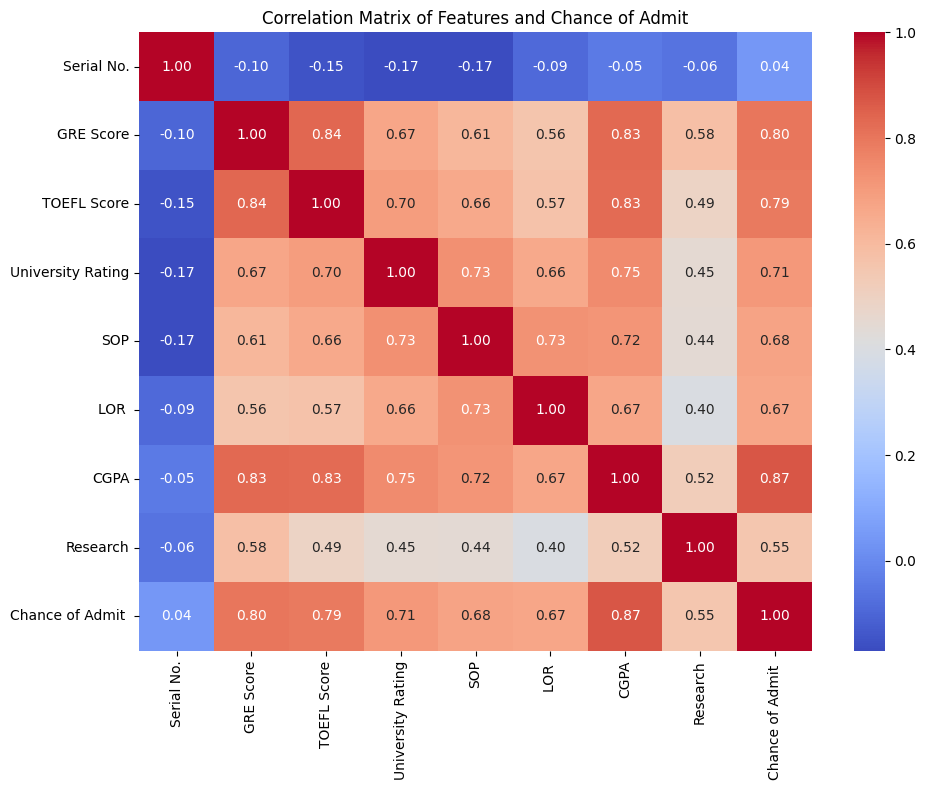

In [130]:
correlation_matrix = df.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Features and Chance of Admit")
plt.tight_layout()
plt.show()


<ipython-input-131-94e0f6736c83>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_admit.values, y=correlation_with_admit.index, palette="coolwarm")


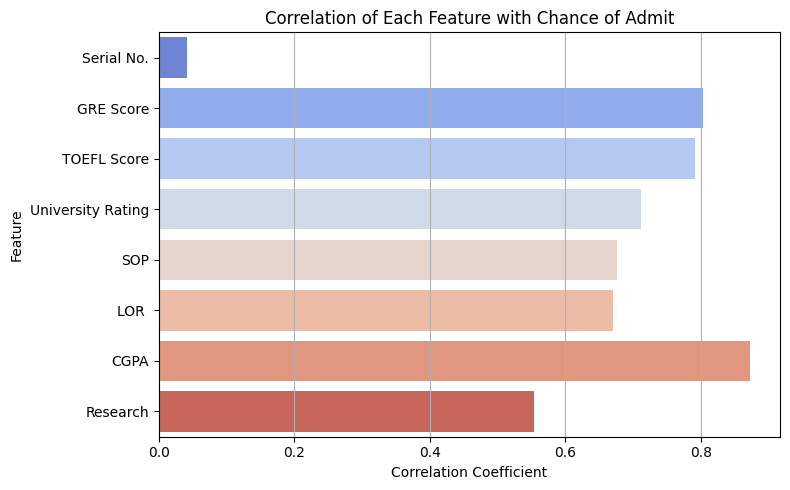

In [131]:
# Ensure exact match for column names
# Compute the correlation matrix
correlation_matrix = df.corr(numeric_only=True)

# Extract correlations with "Chance of Admit"
correlation_with_admit = correlation_matrix.loc[:, "Chance of Admit "].drop("Chance of Admit ")

plt.figure(figsize=(8, 5))
sns.barplot(x=correlation_with_admit.values, y=correlation_with_admit.index, palette="coolwarm")
plt.title("Correlation of Each Feature with Chance of Admit")
plt.xlabel("Correlation Coefficient")
plt.ylabel("Feature")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()


In [132]:
# Step 1: Split data into train/test (85% train, 15% test)
X = df.drop(columns=["Chance of Admit "])
y = df["Chance of Admit "]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Show scaled training data shape
X_train_scaled.shape, X_test_scaled.shape


((340, 8), (60, 8))

In [133]:
#Convert data to PyTorch tensors
X_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

# Split validation set (10% of training data)
X_train_tensor, X_val_tensor, y_train_tensor, y_val_tensor = train_test_split(
    X_tensor, y_tensor, test_size=0.10, random_state=42
)

In [134]:
# Define simple MLP with 1 hidden layer
class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 4),
            nn.ReLU(),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.model(x)

In [135]:
# Define deep MLP with 2 hidden layers
class DeepMLP(nn.Module):
    def __init__(self):
        super(DeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)

In [136]:
def train_model(model, X_train, y_train, X_val, y_val, epochs=500):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    train_losses = []
    val_losses = []

    for epoch in range(epochs):
        # Training step
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

        # Validation step
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val).item()
            val_losses.append(val_loss)

        # Print loss every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Train Loss: {loss.item():.4f}, Validation Loss: {val_loss:.4f}")

    # Compute R^2 score
    model.eval()
    with torch.no_grad():
        val_pred = model(X_val).detach().numpy()
        val_true = y_val.detach().numpy()
        r2 = r2_score(val_true, val_pred)

    # Plot losses
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return val_true, val_pred, r2


Epoch 50/500 - Train Loss: 0.0081, Validation Loss: 0.0076
Epoch 100/500 - Train Loss: 0.0066, Validation Loss: 0.0060
Epoch 150/500 - Train Loss: 0.0056, Validation Loss: 0.0052
Epoch 200/500 - Train Loss: 0.0050, Validation Loss: 0.0048
Epoch 250/500 - Train Loss: 0.0046, Validation Loss: 0.0045
Epoch 300/500 - Train Loss: 0.0044, Validation Loss: 0.0044
Epoch 350/500 - Train Loss: 0.0042, Validation Loss: 0.0043
Epoch 400/500 - Train Loss: 0.0041, Validation Loss: 0.0042
Epoch 450/500 - Train Loss: 0.0039, Validation Loss: 0.0042
Epoch 500/500 - Train Loss: 0.0039, Validation Loss: 0.0041


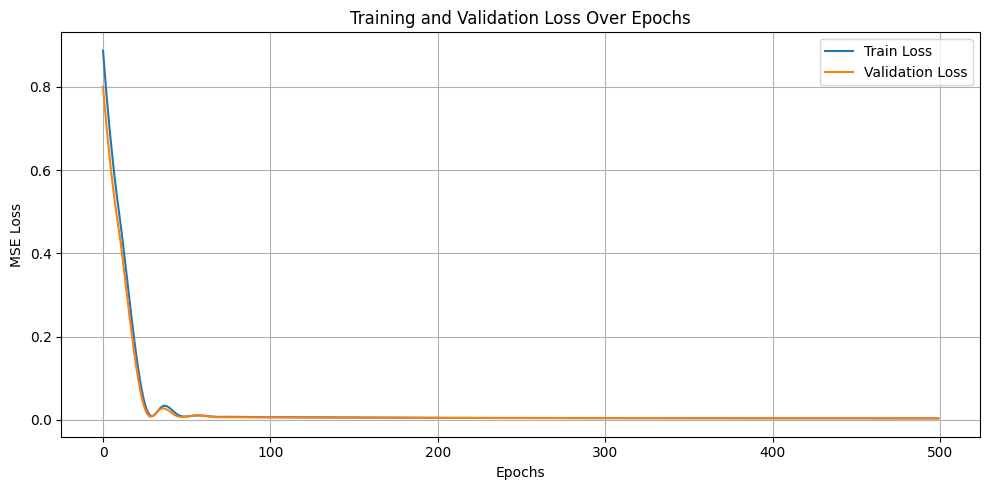

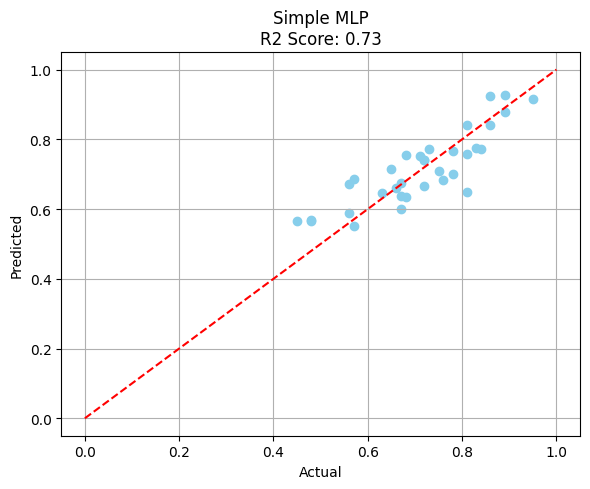

In [137]:
simple_mlp = SimpleMLP()
true_simple, pred_simple, r2_simple = train_model(
    simple_mlp, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=500
)

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(true_simple, pred_simple, color='skyblue')
plt.plot([0, 1], [0, 1], '--r')
plt.title(f"Simple MLP\nR2 Score: {r2_simple:.2f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

Test R² Score: 0.80


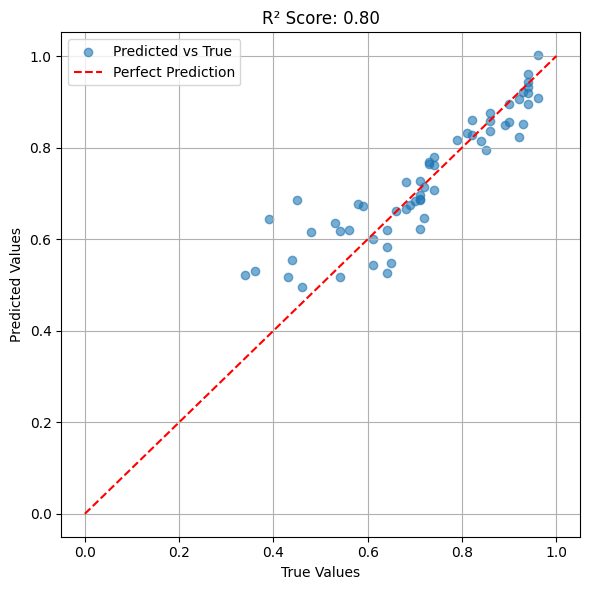

In [138]:
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt

# Compute R² score
r2 = r2_score(test_true, test_pred)
print(f"Test R² Score: {r2:.2f}")

# Plot True vs Predicted values
plt.figure(figsize=(6, 6))
plt.scatter(test_true, test_pred, alpha=0.6, label="Predicted vs True")
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Prediction")  # Line y=x
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"R² Score: {r2:.2f}")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Epoch 50/500 - Train Loss: 0.0041, Validation Loss: 0.0047
Epoch 100/500 - Train Loss: 0.0031, Validation Loss: 0.0047
Epoch 150/500 - Train Loss: 0.0030, Validation Loss: 0.0044
Epoch 200/500 - Train Loss: 0.0030, Validation Loss: 0.0043
Epoch 250/500 - Train Loss: 0.0029, Validation Loss: 0.0042
Epoch 300/500 - Train Loss: 0.0028, Validation Loss: 0.0041
Epoch 350/500 - Train Loss: 0.0027, Validation Loss: 0.0042
Epoch 400/500 - Train Loss: 0.0026, Validation Loss: 0.0042
Epoch 450/500 - Train Loss: 0.0025, Validation Loss: 0.0043
Epoch 500/500 - Train Loss: 0.0024, Validation Loss: 0.0044


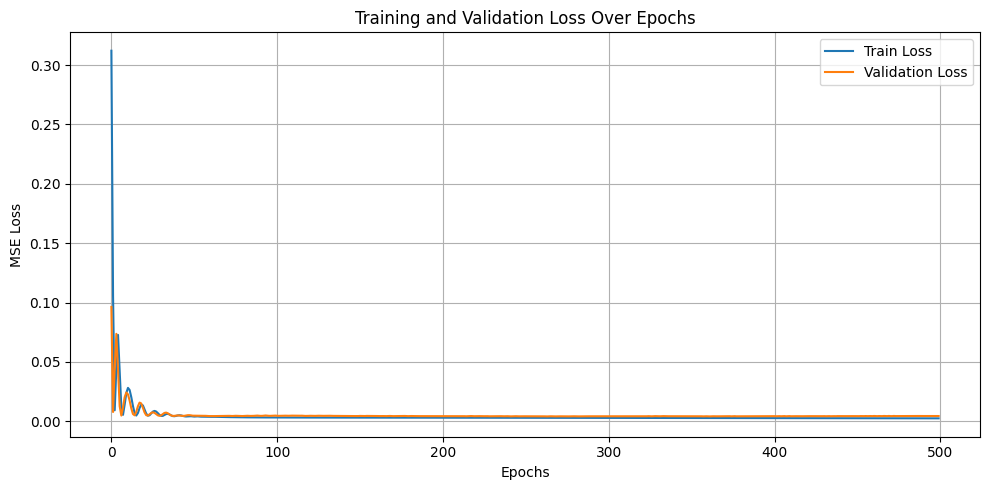

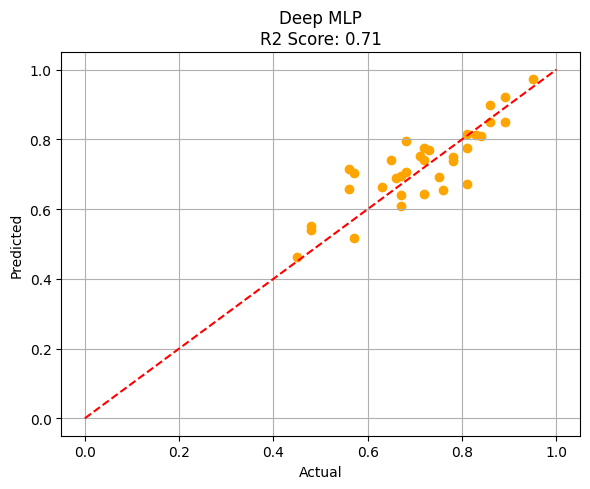

In [139]:
# Train and evaluate Deep model
deep_mlp = DeepMLP()
true_deep, pred_deep, r2_deep = train_model(
    deep_mlp, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor, epochs=500
)

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(true_deep, pred_deep, color='orange')
plt.plot([0, 1], [0, 1], '--r')
plt.title(f"Deep MLP\nR2 Score: {r2_deep:.2f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

Deep MLP Test Accuracy:  0.95
Deep MLP Test Precision: 0.88
Deep MLP Test Recall:    1.00
Deep MLP Test F1 Score:  0.94
Deep MLP Test R² Score:  0.81


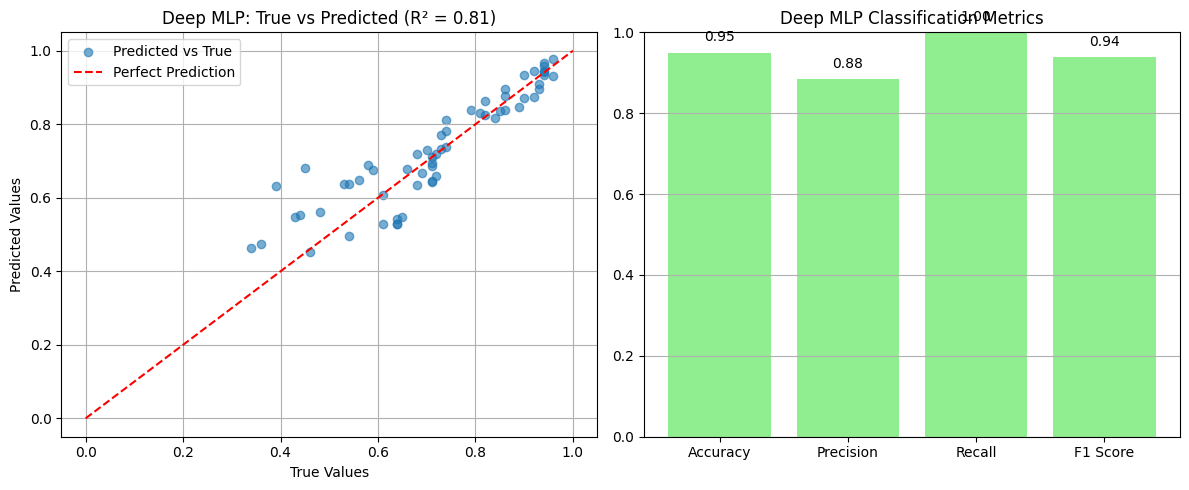

In [148]:
# Predict on test set
deep_mlp.eval()
with torch.no_grad():
    test_pred_deep = deep_mlp(X_test_tensor).detach().numpy()
    test_true_deep = y_test_tensor.detach().numpy()

# Threshold for binary classification
threshold = 0.75
test_pred_binary_deep = (test_pred_deep >= threshold).astype(int)
test_true_binary_deep = (test_true_deep >= threshold).astype(int)

# Compute classification metrics
accuracy_deep = accuracy_score(test_true_binary_deep, test_pred_binary_deep)
precision_deep = precision_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)
recall_deep = recall_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)
f1_deep = f1_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)

# Compute R² score
r2_deep = r2_score(test_true_deep, test_pred_deep)

# Print metrics
print(f"Deep MLP Test Accuracy:  {accuracy_deep:.2f}")
print(f"Deep MLP Test Precision: {precision_deep:.2f}")
print(f"Deep MLP Test Recall:    {recall_deep:.2f}")
print(f"Deep MLP Test F1 Score:  {f1_deep:.2f}")
print(f"Deep MLP Test R² Score:  {r2_deep:.2f}")

# === Plot 1: True vs Predicted values (R² visualization) ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_true_deep, test_pred_deep, alpha=0.6, label="Predicted vs True")
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Deep MLP: True vs Predicted (R² = {r2_deep:.2f})")
plt.legend()
plt.grid(True)

# === Plot 2: Bar chart for classification metrics ===
plt.subplot(1, 2, 2)
metrics_deep = [accuracy_deep, precision_deep, recall_deep, f1_deep]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bars = plt.bar(metric_names, metrics_deep, color='lightgreen')
plt.ylim(0, 1)
plt.title("Deep MLP Classification Metrics")
plt.grid(axis='y')

# Annotate bars
for bar, value in zip(bars, metrics_deep):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [141]:
np.random.seed(42)
random_indices = np.random.choice(len(X_test), size=5, replace=False)

# Get input features and ground truth
samples_X = X_test.iloc[random_indices]
samples_true = y_test.iloc[random_indices].values

# Predict using deep MLP
samples_tensor = torch.tensor(scaler.transform(samples_X), dtype=torch.float32)
deep_mlp.eval()
with torch.no_grad():
    samples_pred = deep_mlp(samples_tensor).numpy().flatten()

# Combine and show
results = pd.DataFrame({
    'GRE Score': samples_X['GRE Score'].values,
    'TOEFL Score': samples_X['TOEFL Score'].values,
    'University Rating': samples_X['University Rating'].values,
    'SOP': samples_X['SOP'].values,
    'LOR': samples_X['LOR '].values,
    'CGPA': samples_X['CGPA'].values,
    'Research': samples_X['Research'].values,
    'Actual Chance': samples_true,
    'Predicted Chance': samples_pred
})

print(results.round(2))


   GRE Score  TOEFL Score  University Rating  SOP  LOR  CGPA  Research  \
0        301          104                  3  3.5  4.0  8.12         1   
1        340          115                  5  4.5  4.5  9.45         1   
2        320          110                  2  4.0  3.5  8.56         0   
3        324          110                  4  4.5  4.0  9.15         1   
4        321          111                  5  5.0  5.0  9.45         1   

   Actual Chance  Predicted Chance  
0           0.68              0.63  
1           0.94              0.94  
2           0.72              0.72  
3           0.82              0.86  
4           0.93              0.90  


Epoch 50/5000 - Train Loss: 0.0046, Validation Loss: 0.0048
Epoch 100/5000 - Train Loss: 0.0035, Validation Loss: 0.0037
Epoch 150/5000 - Train Loss: 0.0032, Validation Loss: 0.0037
Epoch 200/5000 - Train Loss: 0.0031, Validation Loss: 0.0038
Epoch 250/5000 - Train Loss: 0.0030, Validation Loss: 0.0037
Epoch 300/5000 - Train Loss: 0.0029, Validation Loss: 0.0036
Epoch 350/5000 - Train Loss: 0.0028, Validation Loss: 0.0035
Epoch 400/5000 - Train Loss: 0.0027, Validation Loss: 0.0035
Epoch 450/5000 - Train Loss: 0.0025, Validation Loss: 0.0034
Epoch 500/5000 - Train Loss: 0.0025, Validation Loss: 0.0034
Epoch 550/5000 - Train Loss: 0.0024, Validation Loss: 0.0034
Epoch 600/5000 - Train Loss: 0.0023, Validation Loss: 0.0035
Epoch 650/5000 - Train Loss: 0.0023, Validation Loss: 0.0036
Epoch 700/5000 - Train Loss: 0.0022, Validation Loss: 0.0037
Epoch 750/5000 - Train Loss: 0.0022, Validation Loss: 0.0037
Epoch 800/5000 - Train Loss: 0.0021, Validation Loss: 0.0038
Epoch 850/5000 - Train Lo

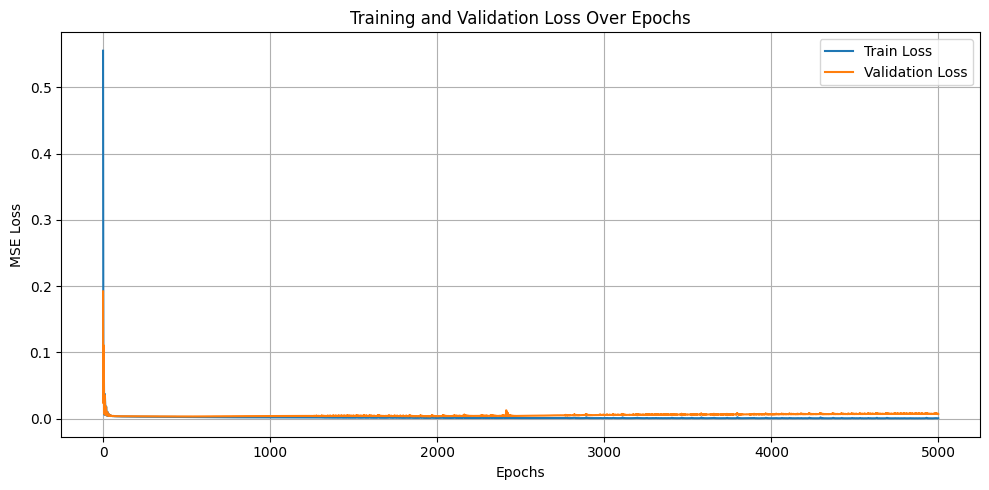

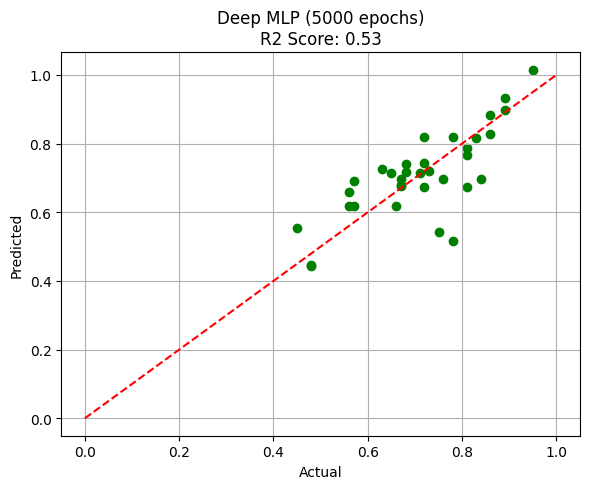

In [142]:
# 1. Retrain DeepMLP with 5000 epochs
long_train_deep_mlp = DeepMLP()

# Early stopping-like mechanism (manual check after training)
true_long, pred_long, r2_long = train_model(
    long_train_deep_mlp,
    X_train_tensor,
    y_train_tensor,
    X_val_tensor,
    y_val_tensor,
    epochs=5000
)

# Plot result
plt.figure(figsize=(6, 5))
plt.scatter(true_long, pred_long, color='green')
plt.plot([0, 1], [0, 1], '--r')
plt.title(f"Deep MLP (5000 epochs)\nR2 Score: {r2_long:.2f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ Notes:
# - We extended training time by 10x
# - Use of ReLU and small batch size may slow convergence
# - Check for overfitting by comparing test R2 with validation R2
# - You can add dropout or reduce learning rate for regularization


Long-Trained Deep MLP Test Accuracy:  0.97
Long-Trained Deep MLP Test Precision: 0.92
Long-Trained Deep MLP Test Recall:    1.00
Long-Trained Deep MLP Test F1 Score:  0.96
Long-Trained Deep MLP Test R² Score:  0.73


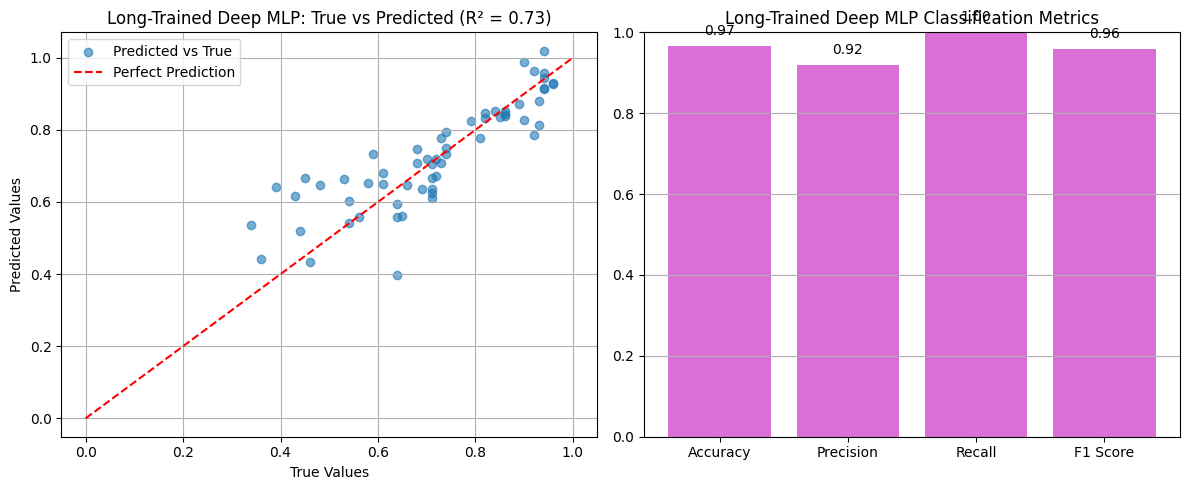

In [149]:
# Predict on test set
long_train_deep_mlp.eval()
with torch.no_grad():
    test_pred_deep = long_train_deep_mlp(X_test_tensor).detach().numpy()
    test_true_deep = y_test_tensor.detach().numpy()

# Threshold for binary classification
threshold = 0.75
test_pred_binary_deep = (test_pred_deep >= threshold).astype(int)
test_true_binary_deep = (test_true_deep >= threshold).astype(int)

# Compute classification metrics
accuracy_deep = accuracy_score(test_true_binary_deep, test_pred_binary_deep)
precision_deep = precision_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)
recall_deep = recall_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)
f1_deep = f1_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)

# Compute R² score
r2_deep = r2_score(test_true_deep, test_pred_deep)

# Print metrics
print(f"Long-Trained Deep MLP Test Accuracy:  {accuracy_deep:.2f}")
print(f"Long-Trained Deep MLP Test Precision: {precision_deep:.2f}")
print(f"Long-Trained Deep MLP Test Recall:    {recall_deep:.2f}")
print(f"Long-Trained Deep MLP Test F1 Score:  {f1_deep:.2f}")
print(f"Long-Trained Deep MLP Test R² Score:  {r2_deep:.2f}")

# === Plot 1: True vs Predicted values (R² visualization) ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_true_deep, test_pred_deep, alpha=0.6, label="Predicted vs True")
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Long-Trained Deep MLP: True vs Predicted (R² = {r2_deep:.2f})")
plt.legend()
plt.grid(True)

# === Plot 2: Bar chart for classification metrics ===
plt.subplot(1, 2, 2)
metrics_deep = [accuracy_deep, precision_deep, recall_deep, f1_deep]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bars = plt.bar(metric_names, metrics_deep, color='orchid')
plt.ylim(0, 1)
plt.title("Long-Trained Deep MLP Classification Metrics")
plt.grid(axis='y')

# Annotate bars
for bar, value in zip(bars, metrics_deep):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()


the f1-score dropped

adding drop out:

In [144]:
# Define deep MLP with 2 hidden layers and dropout
class DeepMLP(nn.Module):
    def __init__(self):
        super(DeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(X_tensor.shape[1], 64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.model(x)


adding early stopping

In [145]:
def train_model_with_early_stopping(model, X_train, y_train, X_val, y_val, epochs=5000, lr=0.001, patience=20, min_delta=1e-4):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_loss = float('inf')
    trigger_times = 0

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(X_train)
        loss = criterion(output, y_train)
        loss.backward()
        optimizer.step()

        # Validation loss
        model.eval()
        with torch.no_grad():
            val_output = model(X_val)
            val_loss = criterion(val_output, y_val).item()

        # Print every 50 epochs
        if (epoch + 1) % 50 == 0:
            print(f"Epoch {epoch + 1}/{epochs} - Validation Loss: {val_loss:.4f}")

        # Early stopping condition
        if best_loss - val_loss > min_delta:
            best_loss = val_loss
            trigger_times = 0
        else:
            trigger_times += 1
            if trigger_times >= patience:
                print(f"\nEarly stopping triggered at epoch {epoch + 1}. Best validation loss: {best_loss:.4f}")
                break

    model.eval()
    with torch.no_grad():
        val_pred = model(X_val).detach().numpy()
        val_true = y_val.detach().numpy()
        r2 = r2_score(val_true, val_pred)
    return val_true, val_pred, r2


Epoch 50/5000 - Validation Loss: 0.0115
Epoch 100/5000 - Validation Loss: 0.0062

Early stopping triggered at epoch 143. Best validation loss: 0.0049


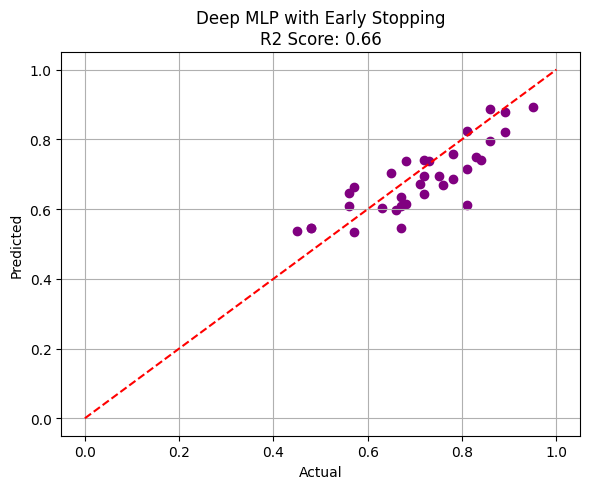

In [146]:
# Train the model with the early stopping configuration
deep_mlp_es = DeepMLP()
true_es, pred_es, r2_es = train_model_with_early_stopping(
    deep_mlp_es, X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor
)

# Plot results
plt.figure(figsize=(6, 5))
plt.scatter(true_es, pred_es, color='purple')
plt.plot([0, 1], [0, 1], '--r')
plt.title(f"Deep MLP with Early Stopping\nR2 Score: {r2_es:.2f}")
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.grid(True)
plt.tight_layout()
plt.show()


Deep MLP (Early Stopping) Test Accuracy:  0.98
Deep MLP (Early Stopping) Test Precision: 1.00
Deep MLP (Early Stopping) Test Recall:    0.96
Deep MLP (Early Stopping) Test F1 Score:  0.98
Deep MLP (Early Stopping) Test R² Score:  0.78


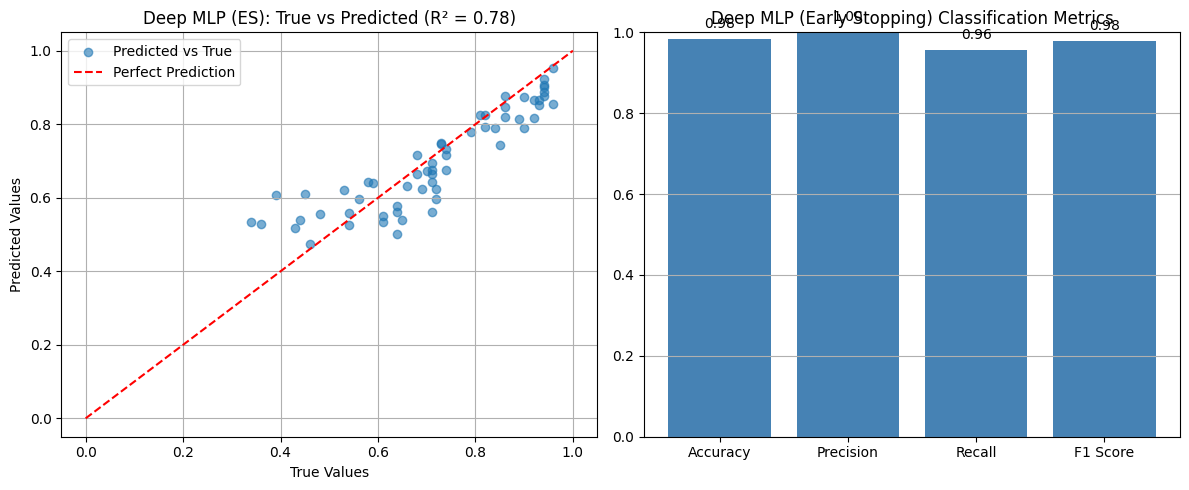

In [150]:
# Predict on test set
deep_mlp_es.eval()
with torch.no_grad():
    test_pred_deep = deep_mlp_es(X_test_tensor).detach().numpy()
    test_true_deep = y_test_tensor.detach().numpy()

# Threshold for binary classification
threshold = 0.75
test_pred_binary_deep = (test_pred_deep >= threshold).astype(int)
test_true_binary_deep = (test_true_deep >= threshold).astype(int)

# Compute classification metrics
accuracy_deep = accuracy_score(test_true_binary_deep, test_pred_binary_deep)
precision_deep = precision_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)
recall_deep = recall_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)
f1_deep = f1_score(test_true_binary_deep, test_pred_binary_deep, zero_division=0)

# Compute R² score
r2_deep = r2_score(test_true_deep, test_pred_deep)

# Print metrics
print(f"Deep MLP (Early Stopping) Test Accuracy:  {accuracy_deep:.2f}")
print(f"Deep MLP (Early Stopping) Test Precision: {precision_deep:.2f}")
print(f"Deep MLP (Early Stopping) Test Recall:    {recall_deep:.2f}")
print(f"Deep MLP (Early Stopping) Test F1 Score:  {f1_deep:.2f}")
print(f"Deep MLP (Early Stopping) Test R² Score:  {r2_deep:.2f}")

# === Plot 1: True vs Predicted values (R² visualization) ===
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(test_true_deep, test_pred_deep, alpha=0.6, label="Predicted vs True")
plt.plot([0, 1], [0, 1], 'r--', label="Perfect Prediction")
plt.xlabel("True Values")
plt.ylabel("Predicted Values")
plt.title(f"Deep MLP (ES): True vs Predicted (R² = {r2_deep:.2f})")
plt.legend()
plt.grid(True)

# === Plot 2: Bar chart for classification metrics ===
plt.subplot(1, 2, 2)
metrics_deep = [accuracy_deep, precision_deep, recall_deep, f1_deep]
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
bars = plt.bar(metric_names, metrics_deep, color='steelblue')
plt.ylim(0, 1)
plt.title("Deep MLP (Early Stopping) Classification Metrics")
plt.grid(axis='y')

# Annotate bars
for bar, value in zip(bars, metrics_deep):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.02,
             f"{value:.2f}", ha='center', va='bottom')

plt.tight_layout()
plt.show()
